<a href="https://colab.research.google.com/github/maki8maki/GCI2023Winter/blob/main/competition2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

参考


*   https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script



Todo


*   欠損値補完
*   パラメタ調整



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/GCI2023Winter/competition2"
INPUT_DIR = "./input/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/GCI2023Winter/competition2


# EDA

In [ ]:
train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")

In [ ]:
train.drop("SK_ID_CURR", axis=1, inplace=True)

In [ ]:
# TARGET=1の割合
avg = np.sum(train['TARGET']==1)/train.shape[0]
print(avg)

0.08072919708881905


## NULL

In [ ]:
train.isnull().sum()

TARGET                              0
NAME_CONTRACT_TYPE                  0
CODE_GENDER                         0
FLAG_OWN_CAR                    34241
FLAG_OWN_REALTY                 34241
CNT_CHILDREN                        0
AMT_INCOME_TOTAL                    0
AMT_CREDIT                          0
AMT_ANNUITY                         6
AMT_GOODS_PRICE                   163
NAME_TYPE_SUITE                   747
NAME_INCOME_TYPE                    0
NAME_EDUCATION_TYPE                 0
NAME_FAMILY_STATUS                  0
NAME_HOUSING_TYPE                   0
REGION_POPULATION_RELATIVE          0
DAYS_BIRTH                          0
DAYS_EMPLOYED                       0
DAYS_REGISTRATION                   0
DAYS_ID_PUBLISH                     0
OWN_CAR_AGE                    112992
FLAG_MOBIL                          0
FLAG_EMP_PHONE                      0
FLAG_WORK_PHONE                     0
FLAG_CONT_MOBILE                    0
FLAG_PHONE                          0
FLAG_EMAIL  

## ２値のobject型のデータを数値型に変換

In [ ]:
# ２値のobject型のデータを数値型にしていく
train['NAME_CONTRACT_TYPE'].replace({'Cash loans': 0, 'Revolving loans':1}, inplace=True)
train['CODE_GENDER'].replace({'F': 0, 'M': 1, 'XNA': np.nan}, inplace=True)
train['FLAG_OWN_CAR'].replace({'N': 0, 'Y': 1}, inplace=True)
train['FLAG_OWN_REALTY'].replace({'N': 0, 'Y': 1}, inplace=True)

## 相関行列

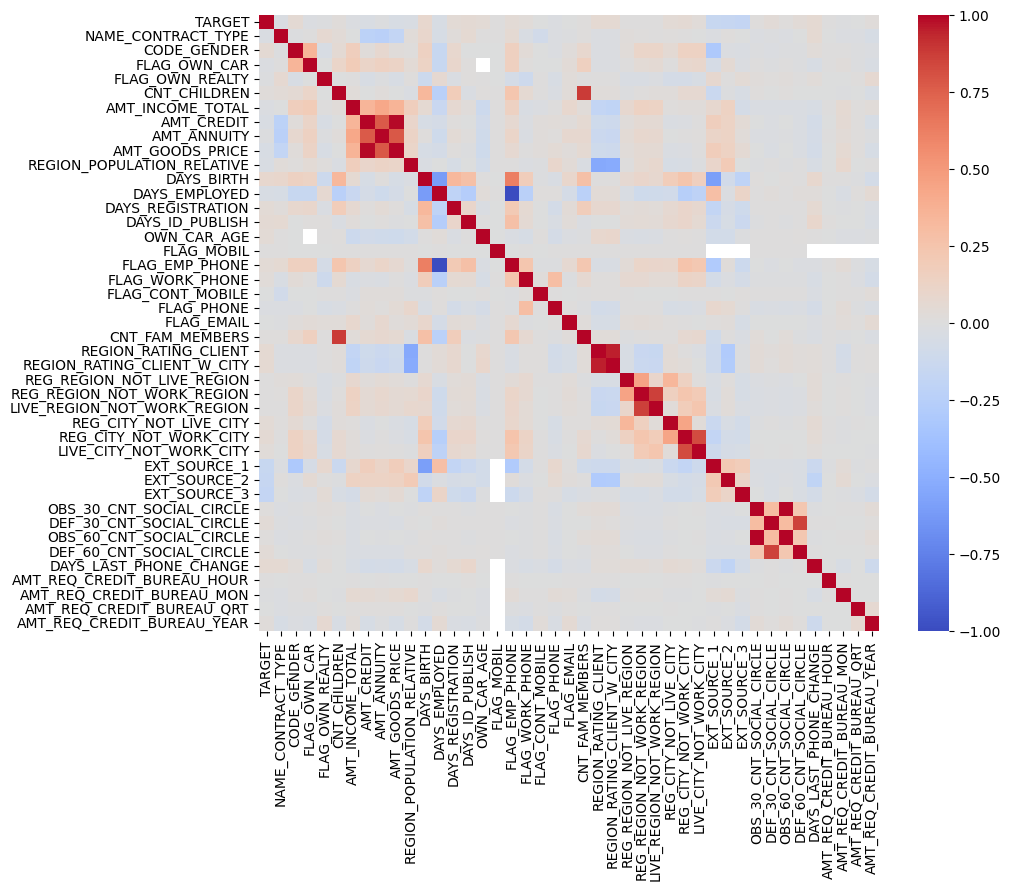

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(data=train.corr(numeric_only=True), vmin=-1, vmax=1,cmap="coolwarm")
plt.show()

メモ\
ターゲットとの相関
* EXT_SOURRCE_1, 2, 3との弱い負の相関
* CODE_GENDER, DAYS_BIRTH, DAYS_REGISTRATION, DAYS_ID_PUBLISHとのとても弱い正の相関

## 各カテゴリーにおける分布

### CODE_GENDER

In [ ]:
train['CODE_GENDER'].value_counts()

F      112549
M       58649
XNA         4
Name: CODE_GENDER, dtype: int64

[ 0.  1. nan]


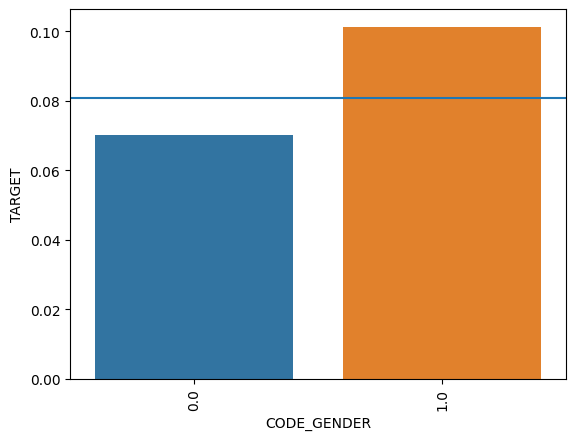

In [ ]:
print(train['CODE_GENDER'].unique())
sns.barplot(x='CODE_GENDER', y='TARGET', data=train, ci=None)
plt.axhline(y=avg)
plt.tick_params(axis="x", rotation=90)

### NAME_CONTRACT_TYPE

[0 1]


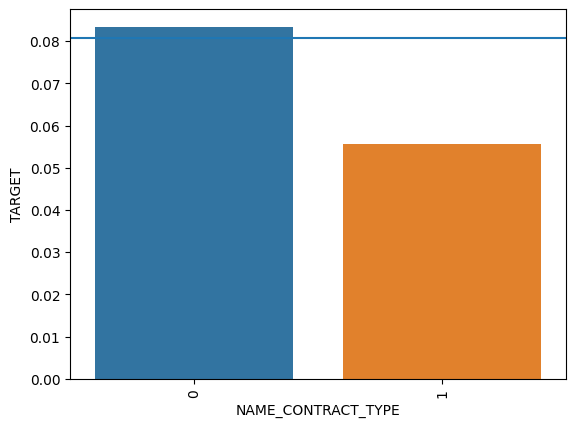

In [ ]:
print(train['NAME_CONTRACT_TYPE'].unique())
sns.barplot(x='NAME_CONTRACT_TYPE', y='TARGET', data=train, ci=None)
plt.axhline(y=avg)
plt.tick_params(axis="x", rotation=90)

### NAME_INCOME_TYPE

['Working' 'Pensioner' 'State servant' 'Commercial associate' 'Student'
 'Businessman' 'Maternity leave' 'Unemployed']


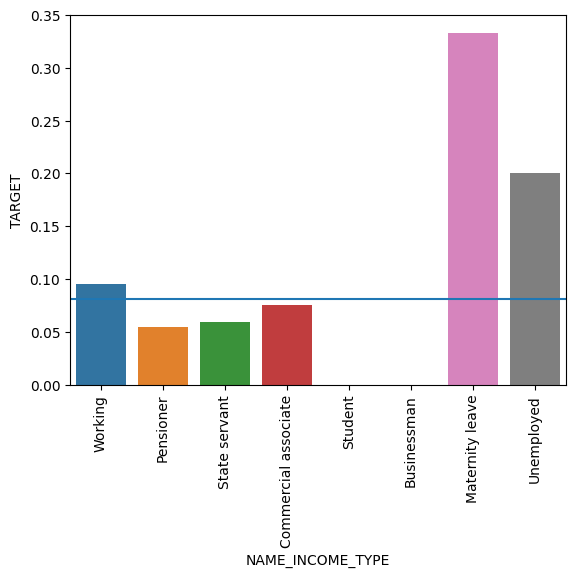

In [ ]:
print(train['NAME_INCOME_TYPE'].unique())
sns.barplot(x='NAME_INCOME_TYPE', y='TARGET', data=train, ci=None)
plt.axhline(y=avg)
plt.tick_params(axis="x", rotation=90)

In [ ]:
train[(train['NAME_INCOME_TYPE']=='Student') | (train['NAME_INCOME_TYPE']=='Businessman')]

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
5840,0,0,1.0,1.0,1.0,2,144000.0,1381113.0,39712.5,1206000.0,...,0.695622,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6990,0,1,0.0,NaN,NaN,0,225000.0,225000.0,11250.0,225000.0,...,NaN,0.0,0.0,0.0,0.0,-709.0,0.0,0.0,0.0,2.0
22753,0,0,1.0,1.0,1.0,0,157500.0,526491.0,28692.0,454500.0,...,NaN,0.0,0.0,0.0,0.0,-706.0,0.0,0.0,0.0,1.0
37910,0,0,1.0,0.0,0.0,0,135000.0,381528.0,24511.5,315000.0,...,0.377404,0.0,0.0,0.0,0.0,-468.0,0.0,0.0,0.0,0.0
50870,0,0,0.0,0.0,0.0,1,225000.0,660289.5,60691.5,585000.0,...,0.535276,0.0,0.0,0.0,0.0,-2563.0,0.0,0.0,0.0,2.0
86725,0,1,1.0,NaN,NaN,0,900000.0,2250000.0,112500.0,2250000.0,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
114562,0,0,1.0,NaN,NaN,2,112500.0,648000.0,19777.5,648000.0,...,0.450747,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0
118753,0,0,0.0,0.0,0.0,0,90000.0,314055.0,16164.0,238500.0,...,NaN,5.0,0.0,5.0,0.0,-3328.0,NaN,NaN,NaN,NaN
124840,0,0,0.0,0.0,1.0,0,171000.0,547272.0,30690.0,495000.0,...,0.681706,0.0,0.0,0.0,0.0,-1929.0,0.0,1.0,0.0,0.0
128761,0,1,0.0,NaN,NaN,0,157500.0,180000.0,9000.0,180000.0,...,NaN,0.0,0.0,0.0,0.0,-694.0,0.0,1.0,0.0,1.0


NAME_INCOME_TYPEがStudentかBusinessmanは必ず0、ただしデータ数が少ないのでそのまま適用するかは検討の余地あり

### NAME_FAMILY_STATUS

['Married' 'Widow' 'Single / not married' 'Separated' 'Civil marriage'
 'Unknown']


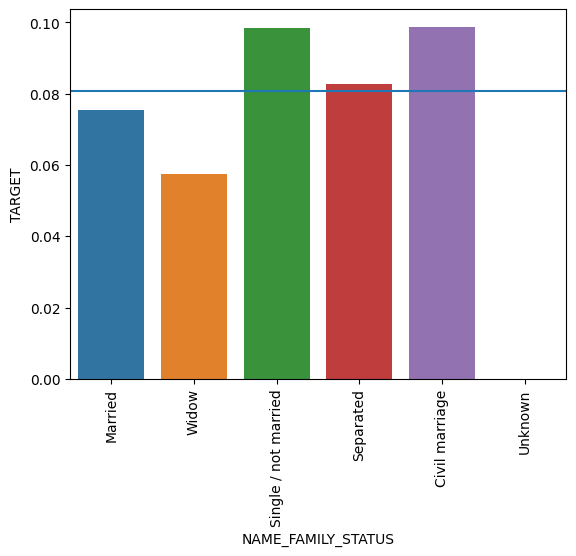

In [ ]:
print(train['NAME_FAMILY_STATUS'].unique())
sns.barplot(x='NAME_FAMILY_STATUS', y='TARGET', data=train, ci=None)
plt.axhline(y=avg)
plt.tick_params(axis="x", rotation=90)

In [ ]:
train[(train['NAME_FAMILY_STATUS']=='Unknown')]

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
47453,0,1,0.0,0.0,1.0,0,202500.0,585000.0,29250.0,NaN,...,0.670652,1.0,0.0,1.0,0.0,-654.0,0.0,0.0,0.0,1.0
74592,0,1,1.0,0.0,1.0,0,450000.0,675000.0,33750.0,NaN,...,NaN,3.0,0.0,3.0,0.0,-876.0,NaN,NaN,NaN,NaN


大きな特徴はなし

### OCCUPATION_TYPE

['Core staff' nan 'Drivers' 'Cleaning staff' 'Cooking staff' 'Managers'
 'Sales staff' 'Laborers' 'Low-skill Laborers' 'Accountants'
 'Private service staff' 'Medicine staff' 'High skill tech staff'
 'Security staff' 'IT staff' 'Waiters/barmen staff' 'Realty agents'
 'Secretaries' 'HR staff']


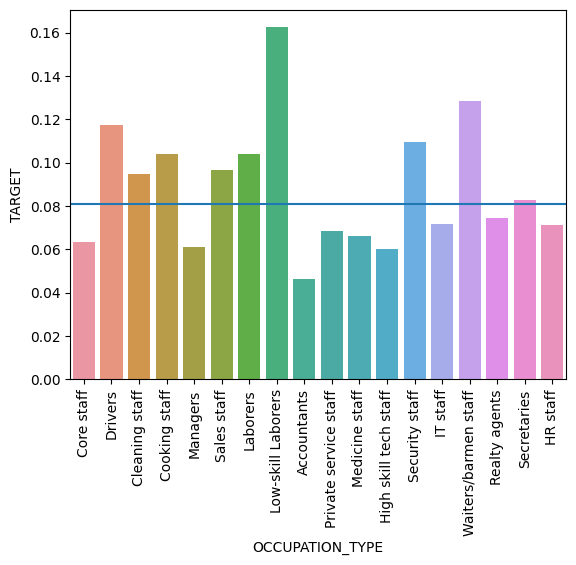

In [ ]:
print(train['OCCUPATION_TYPE'].unique())
sns.barplot(x='OCCUPATION_TYPE', y='TARGET', data=train, ci=None)
plt.axhline(y=avg)
plt.tick_params(axis="x", rotation=90)

### NAME_EDUCATION_TYPE

['Higher education' 'Secondary / secondary special' 'Lower secondary'
 'Incomplete higher' 'Academic degree']


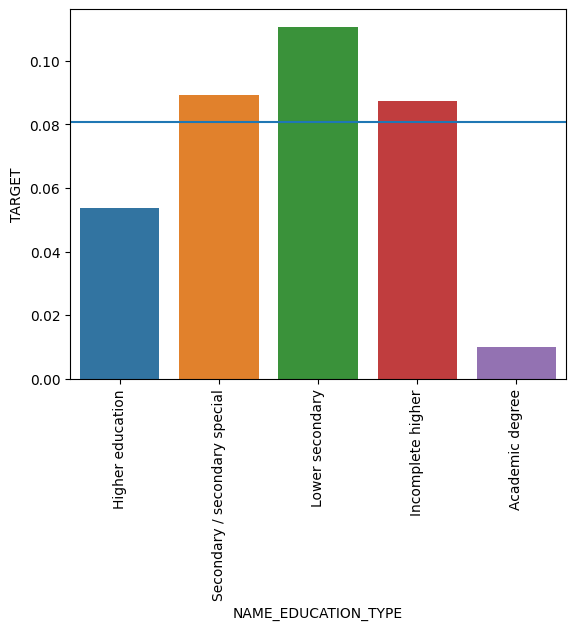

In [ ]:
print(train['NAME_EDUCATION_TYPE'].unique())
sns.barplot(x='NAME_EDUCATION_TYPE', y='TARGET', data=train, ci=None)
plt.axhline(y=avg)
plt.tick_params(axis="x", rotation=90)

### NAME_HOUSING_TYPE

['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']


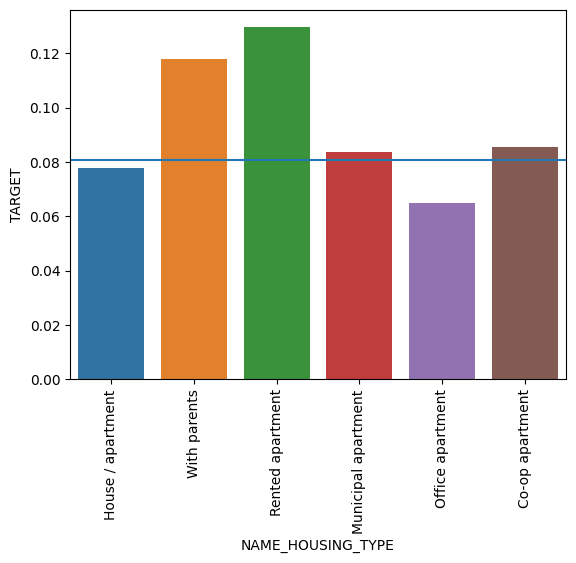

In [ ]:
print(train['NAME_HOUSING_TYPE'].unique())
sns.barplot(x='NAME_HOUSING_TYPE', y='TARGET', data=train, ci=None)
plt.axhline(y=avg)
plt.tick_params(axis="x", rotation=90)

### ORGANIZATION_TYPE

['School' 'XNA' 'Postal' 'Business Entity Type 3' 'Transport: type 4'
 'Trade: type 3' 'Military' 'Self-employed' 'Bank'
 'Business Entity Type 2' 'Kindergarten' 'Trade: type 7' 'Hotel'
 'Services' 'Other' 'Medicine' 'Government' 'Construction' 'Agriculture'
 'University' 'Religion' 'Industry: type 4' 'Advertising' 'Legal Services'
 'Business Entity Type 1' 'Industry: type 9' 'Industry: type 11'
 'Industry: type 3' 'Trade: type 6' 'Industry: type 10' 'Trade: type 1'
 'Housing' 'Industry: type 1' 'Security Ministries' 'Industry: type 12'
 'Security' 'Industry: type 7' 'Transport: type 3' 'Transport: type 2'
 'Police' 'Realtor' 'Restaurant' 'Culture' 'Insurance' 'Emergency'
 'Mobile' 'Electricity' 'Telecom' 'Trade: type 2' 'Industry: type 13'
 'Industry: type 2' 'Transport: type 1' 'Industry: type 5'
 'Industry: type 6' 'Cleaning' 'Trade: type 4' 'Industry: type 8'
 'Trade: type 5']


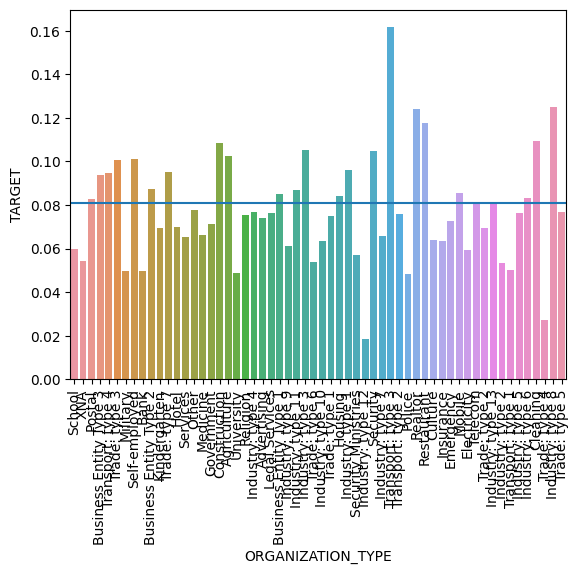

In [ ]:
print(train['ORGANIZATION_TYPE'].unique())
sns.barplot(x='ORGANIZATION_TYPE', y='TARGET', data=train, ci=None)
plt.axhline(y=avg)
plt.tick_params(axis="x", rotation=90)

### NAME_TYPE_SUITE

['Unaccompanied' 'Family' 'Children' 'Spouse, partner' nan 'Other_A'
 'Other_B' 'Group of people']


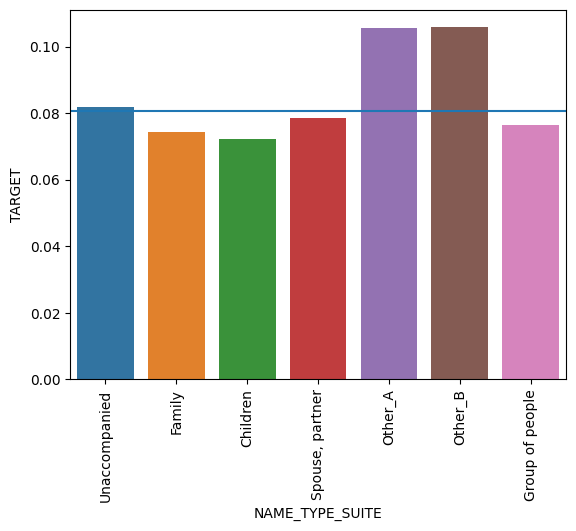

In [ ]:
print(train['NAME_TYPE_SUITE'].unique())
sns.barplot(x='NAME_TYPE_SUITE', y='TARGET', data=train, ci=None)
plt.axhline(y=avg)
plt.tick_params(axis="x", rotation=90)

### FLAG_OWN_CAR

['N' 'Y' nan]


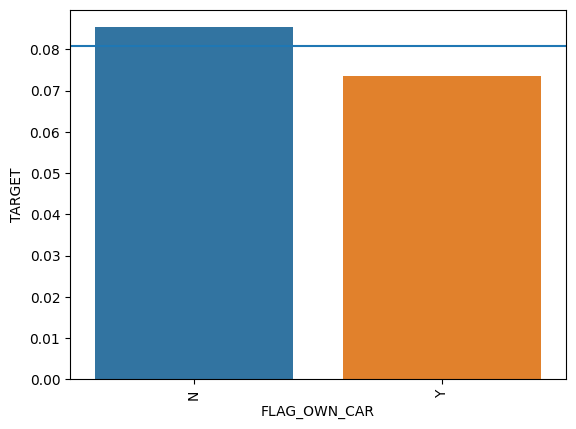

In [ ]:
print(train['FLAG_OWN_CAR'].unique())
sns.barplot(x='FLAG_OWN_CAR', y='TARGET', data=train, ci=None)
plt.axhline(y=avg)
plt.tick_params(axis="x", rotation=90)

## Plot

### OWN_CAR_AGE

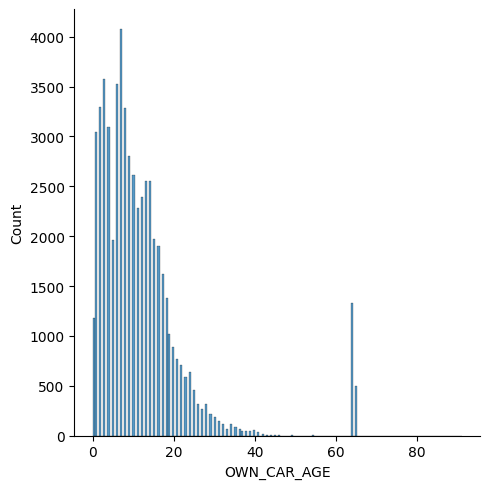

In [ ]:
sns.displot(data=train, x="OWN_CAR_AGE")
plt.show()

### CNT_CHILDREN

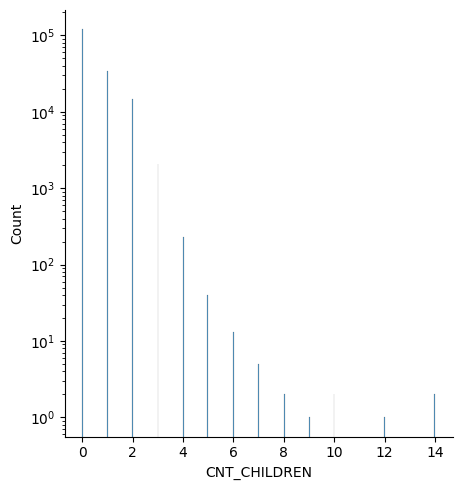

In [ ]:
sns.displot(data=train, x="CNT_CHILDREN")
plt.yscale('log')
plt.show()

### AMT_INCOME_TOTAL

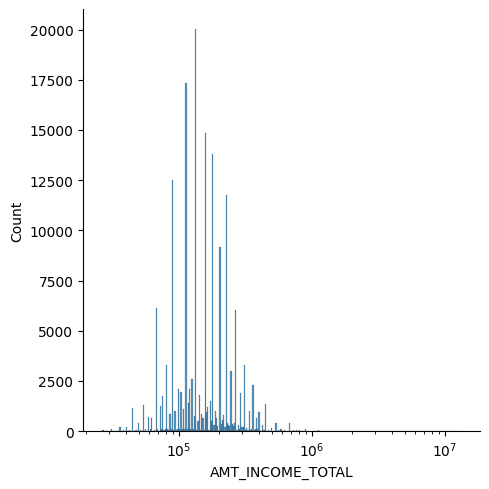

In [ ]:
# logを取って正規分布にする
sns.displot(data=train, x="AMT_INCOME_TOTAL", log_scale=10)
plt.show()

### AMT_ANNUITY

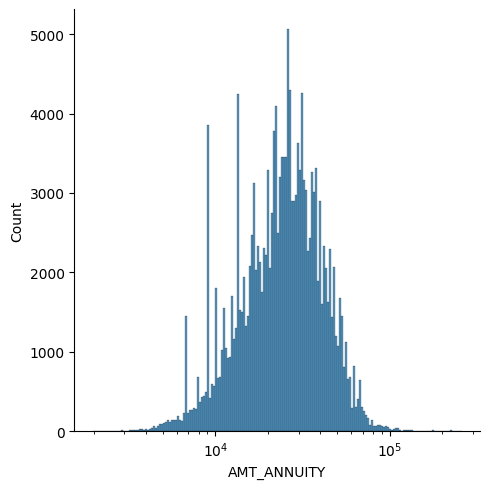

In [ ]:
# logを取って正規分布にする
sns.displot(data=train, x="AMT_ANNUITY", log_scale=10)
plt.show()

### AMT_GOODS_PRICE

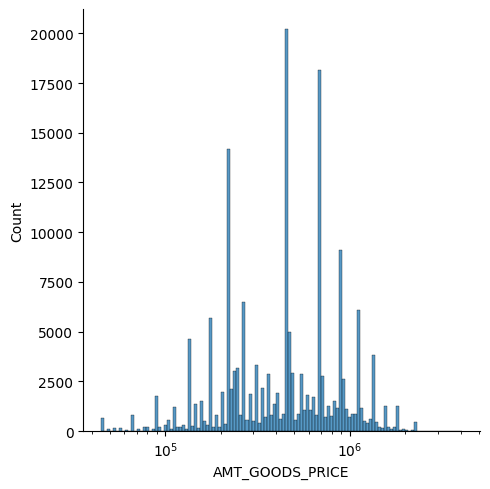

In [ ]:
sns.displot(data=train, x="AMT_GOODS_PRICE", log_scale=10)
plt.show()

### AMT_CREDIT

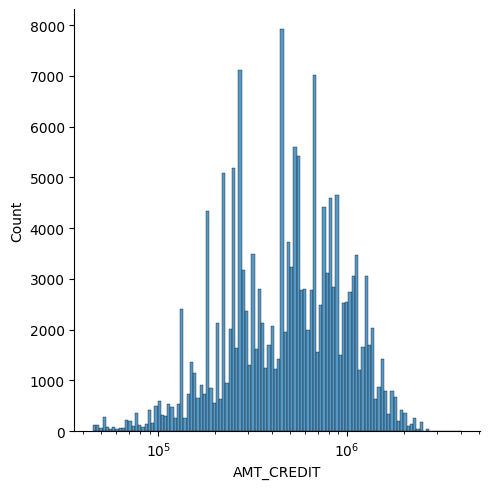

In [ ]:
sns.displot(data=train, x="AMT_CREDIT", log_scale=10)
plt.show()

### REGION_POPULATION_RELATIVE

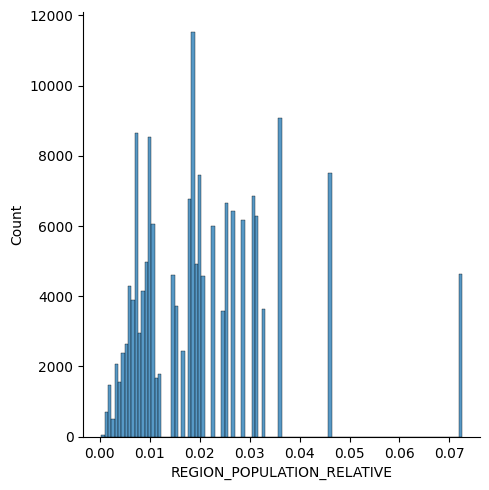

In [ ]:
sns.displot(data=train, x="REGION_POPULATION_RELATIVE")
plt.show()

### DAYS_BIRTH

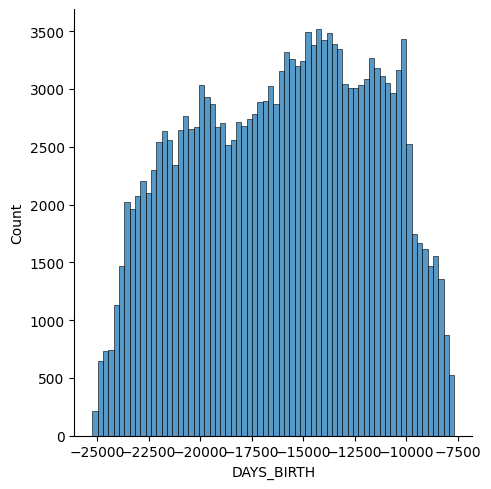

In [ ]:
sns.displot(data=train, x="DAYS_BIRTH")
plt.show()

### DAYS_EMPLOYED

In [ ]:
train[train["DAYS_EMPLOYED"]>0]["DAYS_EMPLOYED"].unique()

array([365243])

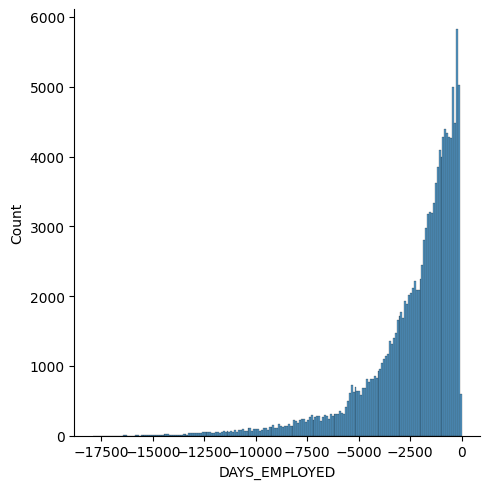

In [16]:
tmp = train[train["DAYS_EMPLOYED"]<=0]
sns.displot(data=tmp, x="DAYS_EMPLOYED")
plt.show()

### DAYS_REGISTRATION

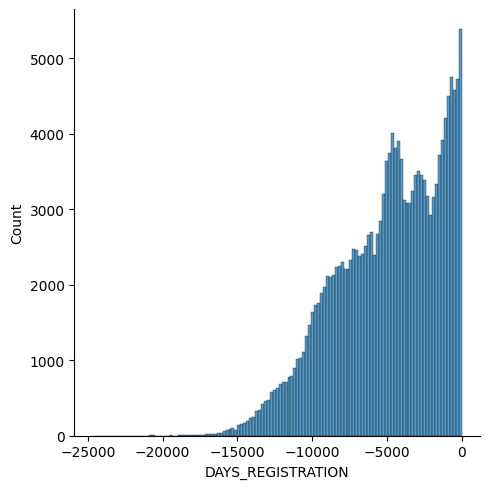

In [ ]:
sns.displot(data=train, x="DAYS_REGISTRATION")
plt.show()

### DAYS_ID_PUBLISH

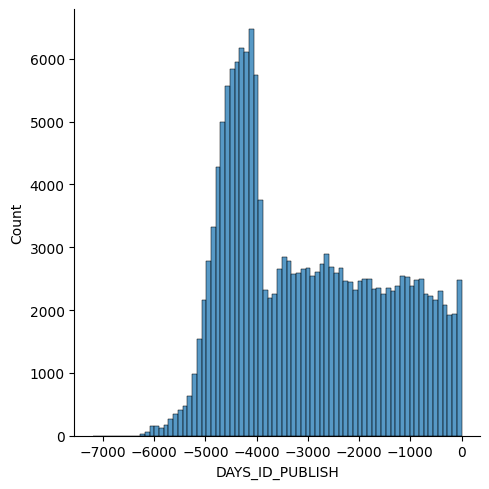

In [ ]:
sns.displot(data=train, x="DAYS_ID_PUBLISH")
plt.show()

### CNT_FAM_MEMBERS

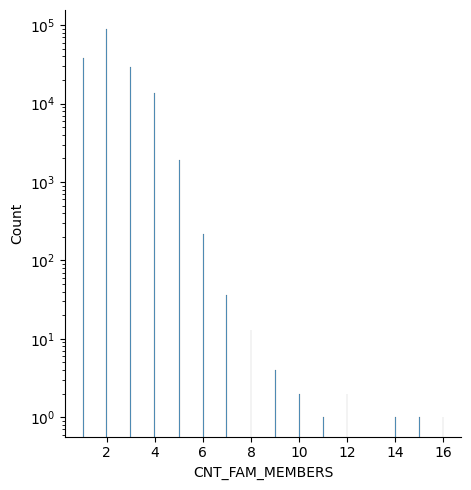

In [ ]:
sns.displot(data=train, x="CNT_FAM_MEMBERS")
plt.yscale('log')
plt.show()

### EXT_SOURCE_1

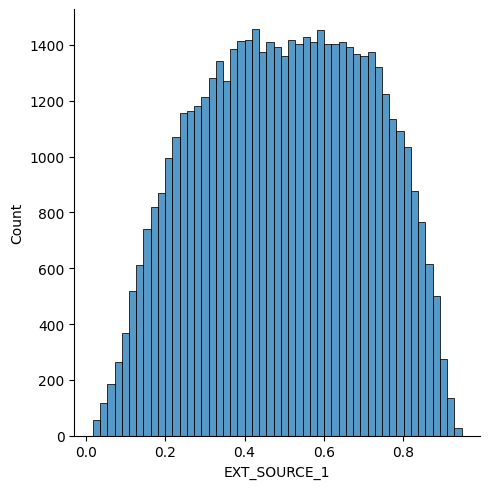

In [ ]:
sns.displot(data=train, x="EXT_SOURCE_1")
plt.show()

### EXT_SOURCE_2

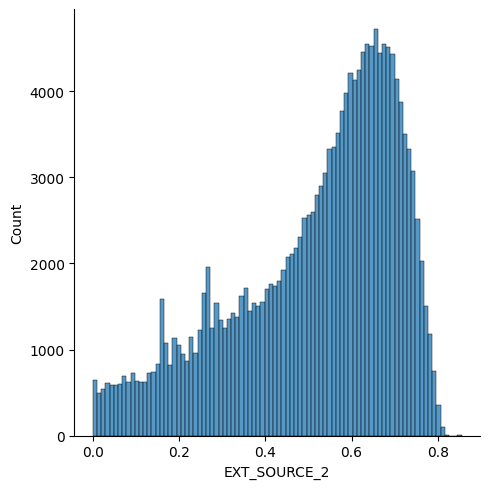

In [ ]:
sns.displot(data=train, x="EXT_SOURCE_2")
plt.show()

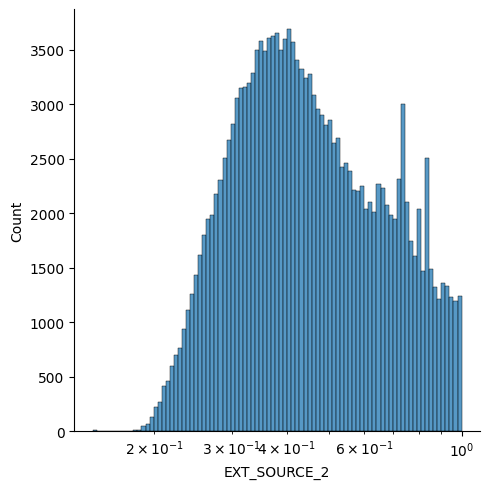

In [ ]:
tmp = -train["EXT_SOURCE_2"] + 1
sns.displot(data=tmp, log_scale=10)
plt.show()

### EXT_SOURCE_3

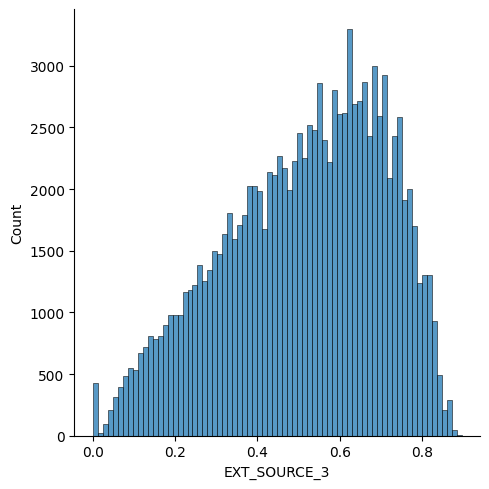

In [ ]:
sns.displot(data=train, x="EXT_SOURCE_3")
plt.show()

### OBS_30_CNT_SOCIAL_CIRCLE

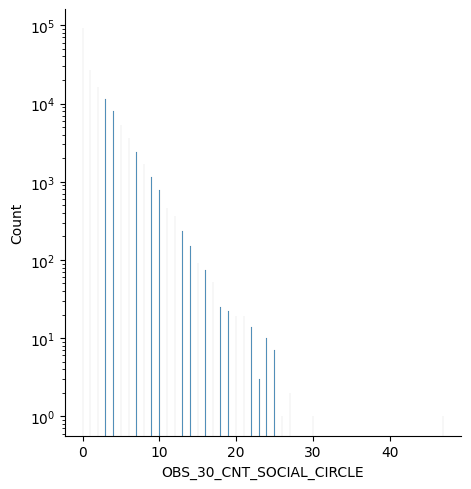

In [ ]:
sns.displot(data=train, x="OBS_30_CNT_SOCIAL_CIRCLE")
plt.yscale('log')
plt.show()

### DEF_30_CNT_SOCIAL_CIRCLE

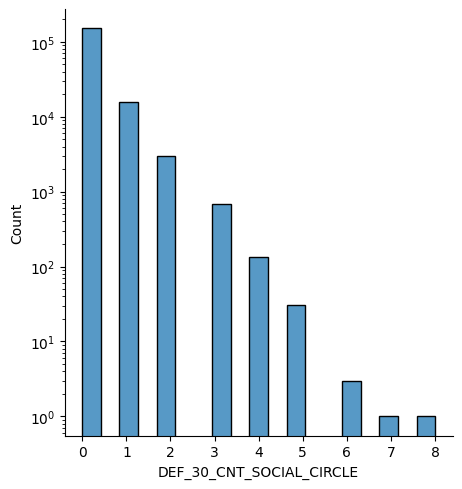

In [ ]:
sns.displot(data=train, x="DEF_30_CNT_SOCIAL_CIRCLE")
plt.yscale('log')
plt.show()

### OBS_60_CNT_SOCIAL_CIRCLE

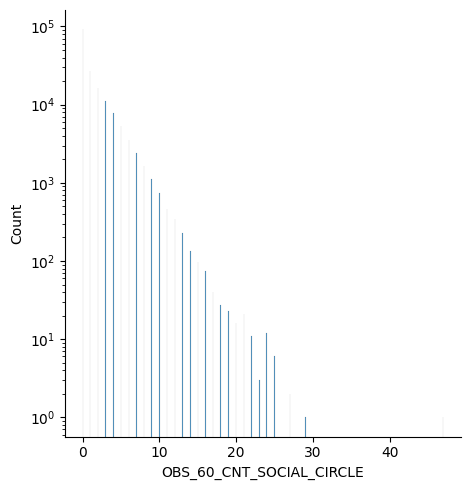

In [ ]:
sns.displot(data=train, x="OBS_60_CNT_SOCIAL_CIRCLE")
plt.yscale('log')
plt.show()

### DEF_60_CNT_SOCIAL_CIRCLE

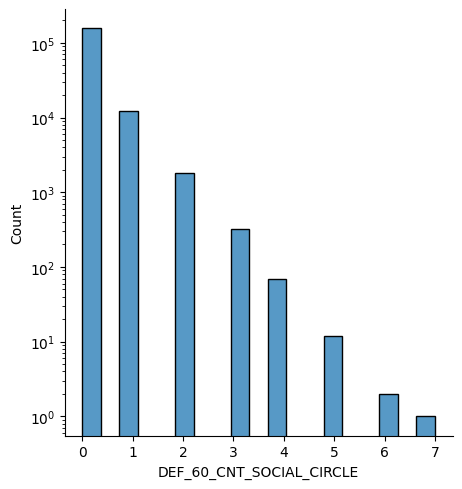

In [ ]:
sns.displot(data=train, x="DEF_60_CNT_SOCIAL_CIRCLE")
plt.yscale('log')
plt.show()

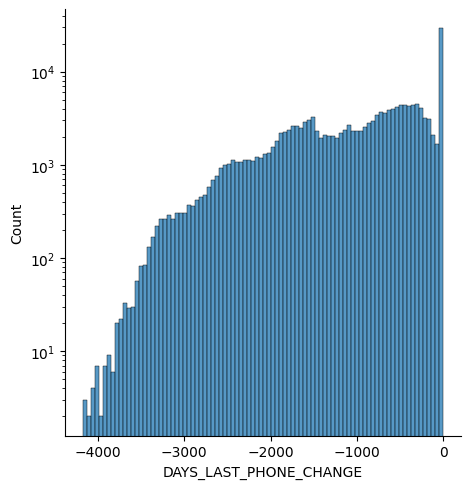

In [ ]:
sns.displot(data=train, x="DAYS_LAST_PHONE_CHANGE")
plt.yscale('log')
plt.show()

### AMT_REQ_CREDIT_BUREAU_HOUR

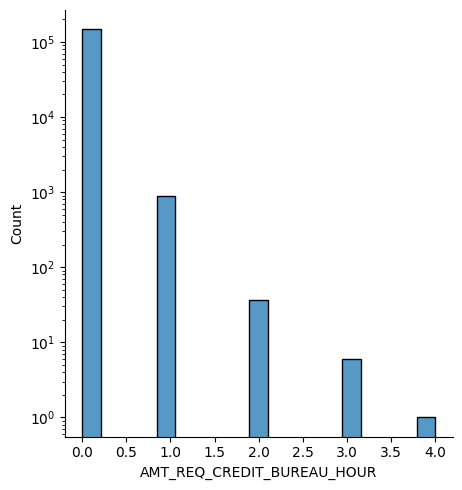

In [ ]:
sns.displot(data=train, x="AMT_REQ_CREDIT_BUREAU_HOUR")
plt.yscale('log')
plt.show()

### AMT_REQ_CREDIT_BUREAU_MON

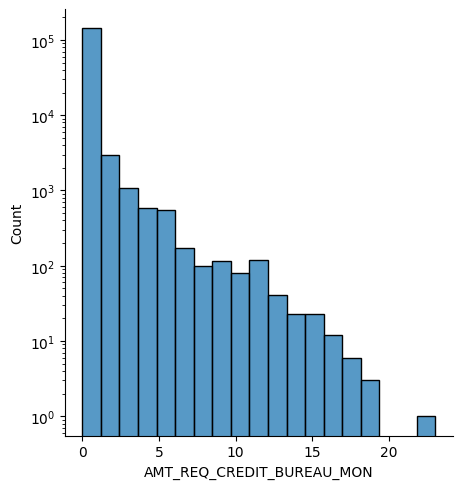

In [ ]:
sns.displot(data=train, x="AMT_REQ_CREDIT_BUREAU_MON")
plt.yscale('log')
plt.show()

### AMT_REQ_CREDIT_BUREAU_QRT

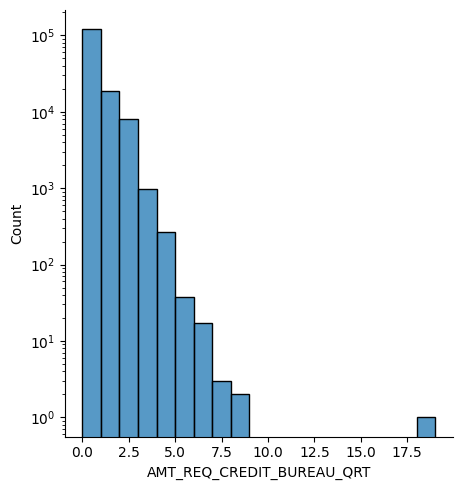

In [ ]:
tmp = train[train['AMT_REQ_CREDIT_BUREAU_QRT']<50]
sns.displot(data=tmp, x="AMT_REQ_CREDIT_BUREAU_QRT")
plt.yscale('log')
plt.show()

### AMT_REQ_CREDIT_BUREAU_YEAR

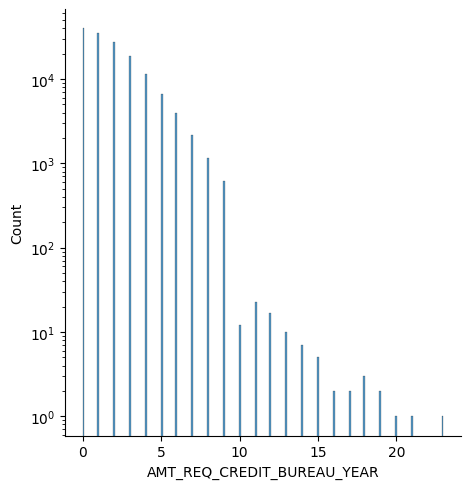

In [ ]:
sns.displot(data=train, x="AMT_REQ_CREDIT_BUREAU_YEAR")
plt.yscale('log')
plt.show()

### DAYS_EMPLOYED_PERC（追加）

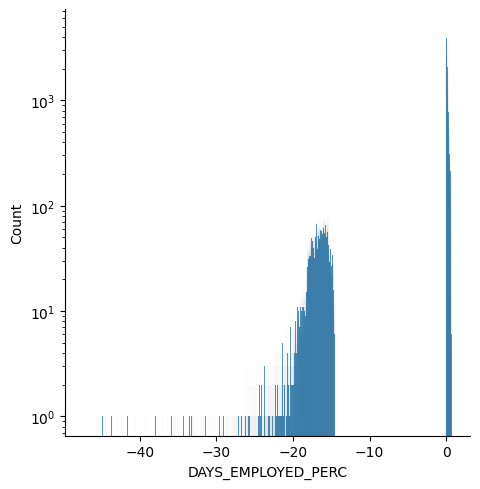

In [ ]:
train['DAYS_EMPLOYED_PERC'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
sns.displot(data=train, x="DAYS_EMPLOYED_PERC")
plt.yscale('log')
plt.show()

### INCOME_CREDIT_PERC（追加）

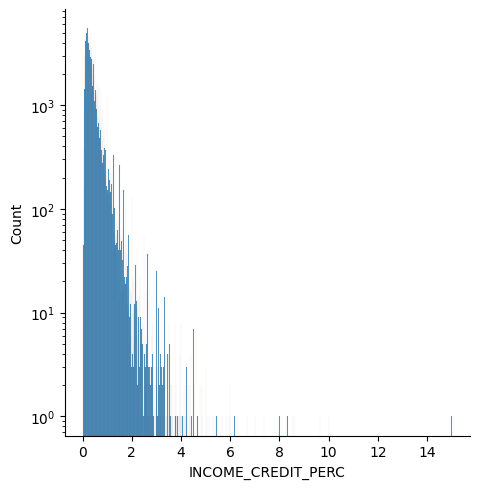

In [ ]:
train['INCOME_CREDIT_PERC'] = train['AMT_INCOME_TOTAL'] / train['AMT_CREDIT']
sns.displot(data=train, x="INCOME_CREDIT_PERC")
plt.yscale('log')
plt.show()

### INCOME_PER_PERSON（追加）

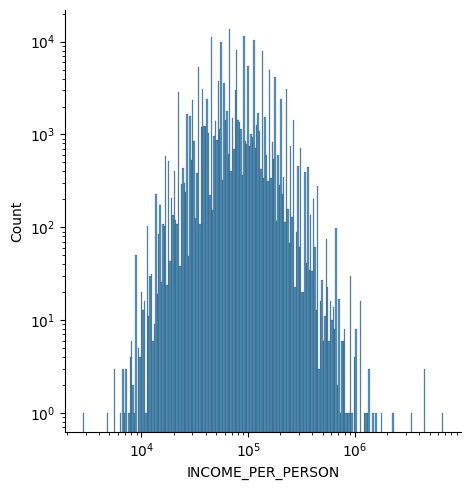

In [ ]:
train['INCOME_PER_PERSON'] = train['AMT_INCOME_TOTAL'] / train['CNT_FAM_MEMBERS']
sns.displot(data=train, x="INCOME_PER_PERSON", log_scale=10)
plt.yscale('log')
plt.show()

### ANNUITY_INCOME_PERC（追加）

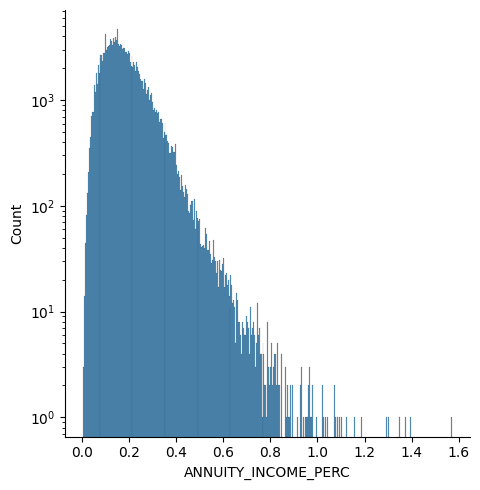

In [ ]:
train['ANNUITY_INCOME_PERC'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
sns.displot(data=train, x="ANNUITY_INCOME_PERC")
plt.yscale('log')
plt.show()

### PAYMENT_RATE（追加）

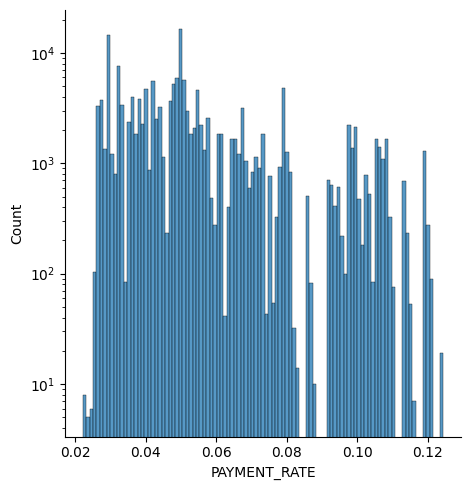

In [ ]:
train['PAYMENT_RATE'] = train['AMT_ANNUITY'] / train['AMT_CREDIT']
sns.displot(data=train, x="PAYMENT_RATE")
plt.yscale('log')
plt.show()

# 提出用推定

## 前処理

In [3]:
train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")
test["TARGET"] = np.nan

df = pd.concat([train, test])
df.drop("SK_ID_CURR", axis=1, inplace=True)

# trainにのみに存在するNaNデータを取り除く
df = df[df['CODE_GENDER'] != 'XNA']

# 外れ値と判断したものをNANに置き換える
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
df.loc[df["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
df.loc[df["AMT_REQ_CREDIT_BUREAU_QRT"] >= 10, "AMT_REQ_CREDIT_BUREAU_QRT"] = np.nan
df.loc[df["OBS_60_CNT_SOCIAL_CIRCLE"] >= 40, "OBS_60_CNT_SOCIAL_CIRCLE"] = np.nan
df.loc[df["OBS_30_CNT_SOCIAL_CIRCLE"] >= 40, "OBS_60_CNT_SOCIAL_CIRCLE"] = np.nan

# 欠損値の補完
tmp = df[df['TARGET'].notnull()]
df["EXT_SOURCE_2"].fillna(tmp["EXT_SOURCE_2"].mean(), inplace=True)
df["EXT_SOURCE_3"].fillna(tmp["EXT_SOURCE_3"].mean(), inplace=True)
df['DAYS_EMPLOYED'].fillna(tmp['DAYS_EMPLOYED'].mode()[0], inplace=True)

# 簡単な特徴量を追加する
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

# 対数変換
log_cols = ['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 'INCOME_PER_PERSON']
df[log_cols] = df[log_cols].apply(np.log, na_action='ignore')

# ラベルが2種類のものはLabel Encodeing
df['NAME_CONTRACT_TYPE'].replace({'Cash loans': 0, 'Revolving loans':1}, inplace=True)
df['CODE_GENDER'].replace({'F': 0, 'M': 1}, inplace=True)
df['FLAG_OWN_CAR'].replace({'N': 0, 'Y': 1}, inplace=True)
df['FLAG_OWN_REALTY'].replace({'N': 0, 'Y': 1}, inplace=True)

# ラベルが3種類以上のものはOne-hot Encoding
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
df = pd.get_dummies(df, columns=categorical_columns, dummy_na=True)

In [ ]:
tmp = df[df['TARGET'].notnull()].isnull().sum()
print(df[df['TARGET'].notnull()].shape)
print(tmp[(tmp!=0)])
tmp = df[df['TARGET'].isnull()].isnull().sum()
print(df[df['TARGET'].isnull()].shape)
print(tmp[(tmp!=0)])

(171198, 168)
FLAG_OWN_REALTY                34240
AMT_ANNUITY                        6
AMT_GOODS_PRICE                  163
DAYS_EMPLOYED                  30898
CNT_FAM_MEMBERS                    2
EXT_SOURCE_1                  118925
EXT_SOURCE_3                   54586
OBS_30_CNT_SOCIAL_CIRCLE         560
DEF_30_CNT_SOCIAL_CIRCLE         560
OBS_60_CNT_SOCIAL_CIRCLE         561
DEF_60_CNT_SOCIAL_CIRCLE         560
DAYS_LAST_PHONE_CHANGE             1
AMT_REQ_CREDIT_BUREAU_HOUR     23116
AMT_REQ_CREDIT_BUREAU_MON      23116
AMT_REQ_CREDIT_BUREAU_QRT      23118
AMT_REQ_CREDIT_BUREAU_YEAR     23116
DAYS_EMPLOYED_PERC             30898
INCOME_PER_PERSON                  2
ANNUITY_INCOME_PERC                6
PAYMENT_RATE                       6
dtype: int64
(61500, 168)
TARGET                        61500
FLAG_OWN_REALTY               12334
AMT_ANNUITY                       3
AMT_GOODS_PRICE                  53
DAYS_EMPLOYED                 10565
EXT_SOURCE_1                  42912
EXT_

## 推定

In [4]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()].drop("TARGET", axis=1)
X = train_df.drop("TARGET", axis=1).values
y = train_df["TARGET"].values

n_splits = 5
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
params = {
    'nthread': 4,
    'n_estimators': 10000,
    'learning_rate': 0.02,
    'num_leaves': 34,
    'colsample_bytree': 0.9497036,
    'subsample': 0.8715623,
    'max_depth': 8,
    'reg_alpha': 0.041545473,
    'reg_lambda': 0.0735294,
    'min_split_gain': 0.0222415,
    'min_child_weight': 39.3259775,
    'random_state': 0,
    'silent': -1,
    'verbose': -1,
}

scores = []
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = test_df.columns
for train_idx, valid_idx in folds.split(X, y):
    X_train_fold, X_valid_fold = X[train_idx], X[valid_idx]
    y_train_fold, y_valid_fold = y[train_idx], y[valid_idx]

    # 多数クラスと少数クラスのサンプル数をカウント
    count_majority = np.sum(y_train_fold == 0)
    count_minority = np.sum(y_train_fold == 1)
    params['scale_pos_weight'] = count_majority / count_minority

    lgbm = LGBMClassifier(**params)
    lgbm.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)], eval_metric='auc',
             callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)])

    calibrated_lgbm = CalibratedClassifierCV(lgbm, method='sigmoid', cv='prefit')
    calibrated_lgbm.fit(X_valid_fold, y_valid_fold)

    prob_val_calibrated = calibrated_lgbm.predict_proba(X_valid_fold)[:, 1]

    sub_preds += calibrated_lgbm.predict_proba(test_df)[:, 1] / folds.n_splits

    auc_score = roc_auc_score(y_valid_fold, prob_val_calibrated)
    scores.append(auc_score)

    # plot用
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = lgbm.feature_importances_
    fold_importance_df["fold"] = n_splits + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

print(np.mean(scores))

0.7177542382245872


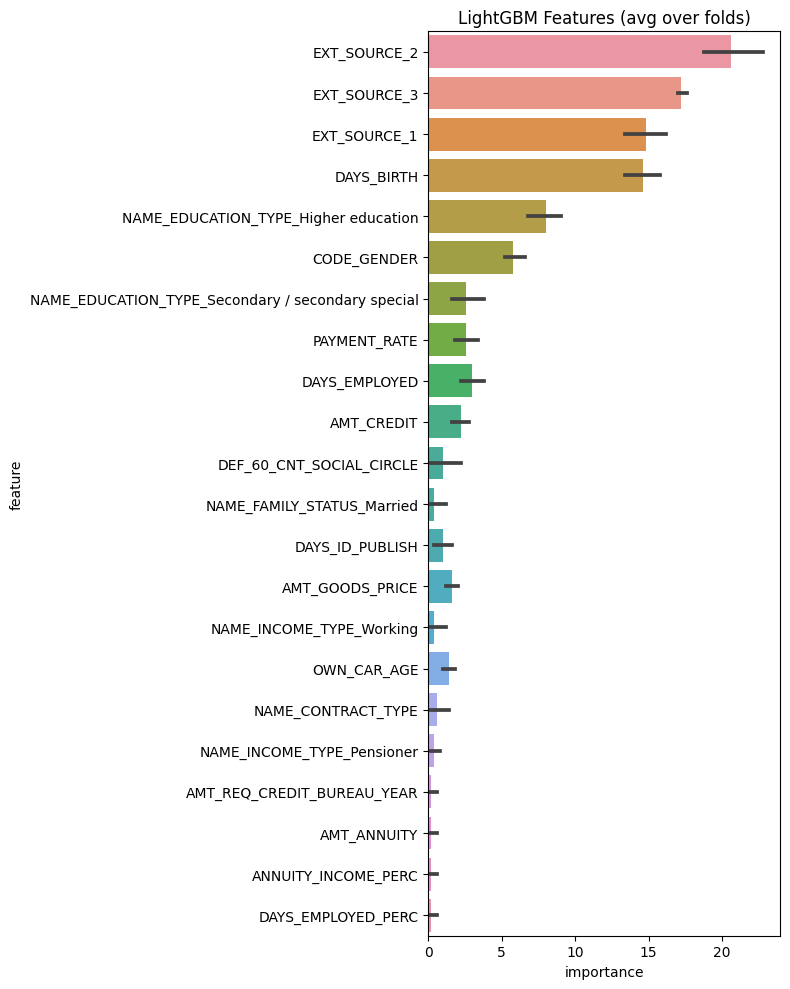

In [5]:
sorted = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
cols = sorted[sorted["importance"]>0].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [6]:
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")
sample_sub['TARGET'] = sub_preds
sample_sub.head(9)

,SK_ID_CURR,TARGET
0,171202,0.026634
1,171203,0.130609
2,171204,0.136968
3,171205,0.174982
4,171206,0.099371
5,171207,0.050226
6,171208,0.183246
7,171209,0.079172
8,171210,0.164635


In [7]:
sample_sub.to_csv('submission.csv',index=False)